# Refresh FSI data in Datamart

In [1]:
import io
import os, glob
import pandas as pd
import json
from requests import get,post,put,delete
from IPython.display import display, HTML

## All parameters are passed from commandline

In [2]:
# Parameters to be injected
template_path = 'FSI_template.tsv'
datasets_path = './datasets'
datamart_api_url = 'http://localhost:12543'
dataset_to_erase = None

### Utilities

In [3]:
def erase_dataset(datamart_api_url: str, dataset_id: str):
    response = delete(f'{datamart_api_url}/metadata/datasets/{dataset_id}?force=true')
    if response.status_code == 400:
        print(json.dumps(response.json(), indent=2))

In [4]:
def upload_data_annotated(file_path, url, put_data=True):
    file_name = os.path.basename(file_path)
    files = {
        'file': (file_name, open(file_path, mode='rb'), 'application/octet-stream')
    }
    if put_data:
        response = put(url, files=files)
    else:
        response = post(url, files=files)
    if response.status_code == 400:
        print(json.dumps(response.json(), indent=2))
    else:
        print(json.dumps(response.json(), indent=2))

In [5]:
def upload_frame_annotated(buffer, url, put_data=True):
    
    buffer.seek(0)
    
    files = {
        'file': ('buffer.csv', buffer, 'application/octet-stream')
    }
    
    if put_data:
        response = put(url, files=files)
    else:
        response = post(url, files=files)
    if response.status_code == 400:
        print(json.dumps(response.json(), indent=2))

### Remove datasets when needed

In [6]:
if not dataset_to_erase is None:
    erase_dataset(datamart_api_url, dataset_to_erase)

### Load template into memory

In [7]:
def get_template(template_path: str):
    if not os.path.isfile(template_path):
        raise FileNotFoundError("Template file does not exist!")
    return pd.read_csv(template_path, sep='\t', dtype=object, header=None).fillna('')

In [8]:
df_template = get_template(template_path)
df_template

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,dataset,FSI,FSI dataset,data downloaded from FSI,https://fragilestatesindex.org,,,,,,,,,,,,
1,role,main subject,time,,,variable,variable,variable,variable,variable,variable,variable,variable,variable,variable,variable,variable
2,type,country,%Y-%m-%d %H:%M:%S,,,number,number,number,number,number,number,number,number,number,number,number,number
3,description,,,,,,,,,,,,,,,,
4,name,,,,,,,,,,,,,,,,
5,unit,,,,,,,,,,,,,,,,
6,header,Country,Year,Rank,Total,C1: Security Apparatus,C2: Factionalized Elites,C3: Group Grievance,E1: Economy,E2: Economic Inequality,E3: Human Flight and Brain Drain,P1: State Legitimacy,P2: Public Services,P3: Human Rights,S1: Demographic Pressures,S2: Refugees and IDPs,X1: External Intervention


### Build the pattern of files to be uploaded

In [9]:
def generate_targets(datasets_path: str):
    patterns = []
    if datasets_path.endswith('/'):
        datasets_path = datasets_path[:-1]
    patterns.append(datasets_path + '/*.csv')
    patterns.append(datasets_path + '/*.xlsx')
    return patterns

patterns = generate_targets(datasets_path)

### Build the sheet to be uploaded

In [10]:
def get_sheet(filename: str, nCols: int) -> pd.core.frame.DataFrame:
    
    # Only extract the first nCols columns specified in the template
    # Read with headers
    sheet = pd.DataFrame()
    if filename.endswith('.xlsx'):
        sheet = pd.read_excel(filename, dtype=object).fillna('')
    elif filename.endswith('.csv'):
        sheet = pd.read_csv(filename, encoding='latin1', dtype=object).fillna('')
    else:
        raise ValueError(f'Not supported type: {filename}')
        
    sheet = sheet[sheet.columns[:nCols]]
    return sheet

In [11]:
def get_dataInd(template: pd.core.frame.DataFrame, df: pd.core.frame.DataFrame) -> int:
    start_ind = 0
    for j in range(len(df_template.columns)):
        # Check the variable column only
        if df_template.iloc[1,j] == 'variable' and df_template.iloc[2,j] == 'number':
            ind = 0
            while True:
                try:
                    float(df.iloc[ind, j])
                    break
                except:
                    ind += 1
            start_ind = max(start_ind, ind)
    return start_ind

In [12]:
dataset_id = df_template.iloc[0,1]
# Number of variables to be uploaded, omit the first column (metadata)
nCols = len(df_template.iloc[0]) - 1

In [13]:
# This sheet holds all the datapoints to be uploaded
annotated_sheet = get_template(template_path)
add_datatag = False

In [14]:
for p in patterns:
    for filename in glob.iglob(p):
        
        # Generate the sheet        
        sheet = get_sheet(filename, nCols)

        # Verify Label matches
        if False in sheet.columns == df_template.iloc[6][1:]:
            raise ValueError(f'Columns do not match between template and input: {data_path}. Abort...')

        # Build inputs
        sheet.insert(loc=0, column='', value='')
        
        # Search for the starting row index of the data segment
        data_index = get_dataInd(df_template, sheet)
        
        if not add_datatag:
            sheet.iloc[data_index,0] = 'data'
            add_datatag = True

        # Build annotated data
        sheet.columns = annotated_sheet.columns
        annotated_sheet = annotated_sheet.append(sheet[data_index:])

### Post the annotated sheet to datamart

In [15]:
buffer = io.StringIO()
annotated_sheet.to_csv(buffer, index=False, header=False)
url = f'{datamart_api_url}/datasets/{dataset_id}/annotated?create_if_not_exist=true'
upload_frame_annotated(buffer, url, False)

### Check the data has been uploaded

In [16]:
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
q_variable = 'c1_security_apparatus'
q_country = 'Gabon'
response = get(f'{datamart_api_url}/datasets/{dataset_id}/variables/{q_variable}?country={q_country}')
df = pd.read_csv(io.StringIO(response.text))

In [18]:
y = df['value']
x = df['time'].apply(lambda t: datetime.strptime(t,'%Y-%m-%dT%H:%M:%SZ').year)

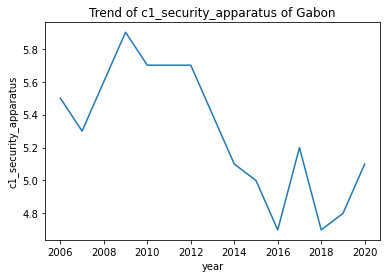

In [19]:
fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='year', ylabel=q_variable, title=f'Trend of {q_variable} of {q_country}')
plt.show()